#  Predicting Road Accident Risk
##  Notebook 2: Linear Baseline & Ridge Regression

**Proje Ekibi:**
* **Esmanur Ulu** - 231101024
* **Nehir Tıraş** - 231101065
* **Zeynep Yetkin** - 231101042

---

### Notebook Amacı: Taban Puanı (Baseline) Belirlemek

Bu notebook, trafik kazası riski tahmini projesi kapsamında oluşturulan **ilk modelleme** çalışmasıdır. Karmaşık Derin Öğrenme (Deep Learning) modellerine geçmeden önce, problemin zorluk derecesini anlamak ve diğer modellerin geçmesi gereken bir **"Referans Performans" (Baseline Score)** oluşturmak hedeflenmektedir.

**Süreç Adımları:**
1.  **Veri Yükleme:** Notebook 1'de temizlenen ve kaydedilen (`processed/`) verilerin içeri aktarılması.
2.  **Basit Regresyon (OLS):** Herhangi bir düzenlileştirme olmadan ham performansın ölçülmesi.
3.  **Ridge Regression (L2):** Aşırı öğrenmeyi (overfitting) engellemek için cezalı regresyon modelinin kurulması.
4.  **Hiperparametre Optimizasyonu:** Ridge için en iyi $\alpha$ (alpha) değerinin bulunması.
5.  **Model Kaydı:** En iyi performans veren lineer modelin `.pkl` formatında kaydedilmesi.

---

### Neden Ridge Regression Tercih Edildi?

Standart Lineer Regresyon (OLS), veri setimizdeki bazı yapısal özellikler nedeniyle kararsız (unstable) sonuçlar üretebilir:
* **Çoklu Doğrusal Bağlantı (Multicollinearity):** Özellikle `One-Hot Encoding` sonrası oluşan sütunlar arasında yüksek korelasyon olabilir.
* **Yüksek Boyut:** İşlenmiş veri setindeki sütun sayısının artması, standart regresyonun katsayıları aşırı büyütmesine neden olabilir.

**Ridge Regression (L2 Regularization) Çözümü:**
* Hata fonksiyonuna bir **ceza terimi (penalty term)** ekleyerek katsayıların (weights) aşırı büyümesini engeller.
* Varyansı azaltarak modelin görmediği verilerde (Validation/Test) daha tutarlı çalışmasını sağlar.
* Akademik literatürde, Derin Öğrenme modellerinin başarısını kıyaslamak için **"Gold Standard" (Altın Standart)** baseline model olarak kabul edilir.

## 1. İşlenmiş Verilerin Yüklenmesi (Loading Processed Data)

Model eğitim sürecine başlamadan önce, **Notebook 1: Data Preprocessing Pipeline** aşamasında titizlikle hazırlanan ve `processed/` klasörüne kaydedilen veri setleri belleğe yüklenmektedir.

**Yüklenecek Dosyalar:**
* `X_train_processed.csv`: Eğitim verisinin öznitelikleri (Features).
* `y_train.csv`: Eğitim verisinin hedef değişkeni (Target - Accident Risk).
* `X_val_processed.csv`: Doğrulama verisinin öznitelikleri.
* `y_val.csv`: Doğrulama verisinin hedef değişkeni.

**Veri Durumu:**
Bu dosyalar, önceki aşamadaki Pipeline işleminden geçtiği için:
* Tüm kategorik değişkenler **One-Hot Encoded** formatındadır.
* Sayısal değişkenler **StandardScaler** ile normalize edilmiştir.
* Veri seti, herhangi bir ek işlem gerektirmeden doğrudan **Ridge Regression** modeline girmeye hazırdır.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

base_path = "/content/drive/MyDrive/YAP470_Proje"
processed_path = os.path.join(base_path, "processed")

print(f"Veri Okuma Yolu: {processed_path}")
print("-" * 30)

try:
    X_train = pd.read_csv(os.path.join(processed_path, "X_train_processed.csv"))
    y_train = pd.read_csv(os.path.join(processed_path, "y_train.csv"))

    X_val = pd.read_csv(os.path.join(processed_path, "X_val_processed.csv"))
    y_val = pd.read_csv(os.path.join(processed_path, "y_val.csv"))


    y_train = y_train.values.ravel()
    y_val = y_val.values.ravel()


    print(f"X_train yüklendi. Boyut: {X_train.shape}")
    print(f"y_train yüklendi. Boyut: {y_train.shape}")
    print("-" * 20)
    print(f"X_val   yüklendi. Boyut: {X_val.shape}")
    print(f"y_val   yüklendi. Boyut: {y_val.shape}")

except FileNotFoundError:
    print("Dosyalar bulunamadı!")

Veri Okuma Yolu: /content/drive/MyDrive/YAP470_Proje/processed
------------------------------
X_train yüklendi. Boyut: (414203, 20)
y_train yüklendi. Boyut: (414203,)
--------------------
X_val   yüklendi. Boyut: (103551, 20)
y_val   yüklendi. Boyut: (103551,)


## 2. Baseline Model: Ordinary Least Squares (OLS)

Karmaşık ve hesaplama maliyeti yüksek algoritmalara (Ridge, Neural Networks, XGBoost) geçmeden önce, problemin çözümüne dair bir **alt sınır (lower bound)** belirlemek için en temel yöntem olan **Standart Lineer Regresyon (OLS)** modeli kurulacaktır.

**Bu Modelin Amacı:**

1.  **Referans Noktası (Benchmark):** İleride kuracağımız gelişmiş modellerin başarısını kıyaslayabileceğimiz bir taban puan oluşturmak. (Örn: "Neural Network, Baseline modele göre hatayı %20 azalttı" diyebilmek).
2.  **Veri Kalite Kontrolü:** Önceki aşamada yapılan *Preprocessing* işlemlerinin (Scaling, Encoding) model tarafından anlaşılabilir olduğunu doğrulamak.
3.  **Problemin Doğası:** Eğer basit bir lineer model bile çok yüksek başarı (Örn: $R^2 > 0.90$) veriyorsa, karmaşık modellere ihtiyaç olmayabilir. Ancak düşük başarı, problemin **non-linear (doğrusal olmayan)** yapısını kanıtlar.

> **Not:** Bu aşamada herhangi bir *Regularization* (Ridge/Lasso) uygulanmayacak, saf Regresyon denklemi çözülecektir.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
y_pred_train = ols_model.predict(X_train)
y_pred_val   = ols_model.predict(X_val)


rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val   = np.sqrt(mean_squared_error(y_val, y_pred_val))


r2_train = r2_score(y_train, y_pred_train)
r2_val   = r2_score(y_val, y_pred_val)

print(f"BASELINE MODEL (OLS) SONUÇLARI")
print("-" * 40)
print(f"Eğitim Seti (Train) RMSE : {rmse_train:.5f}")
print(f"Doğrulama Seti (Val) RMSE: {rmse_val:.5f}")
print("-" * 40)
print(f"Eğitim Seti (Train) R2   : {r2_train:.5f}")
print(f"Doğrulama Seti (Val) R2  : {r2_val:.5f}")


print("-" * 40)
if rmse_train < rmse_val:
    diff = rmse_val - rmse_train
    print(f"Fark (Overfitting Sinyali): {diff:.5f}")
else:
    print("Model tutarlı görünüyor (Underfitting ihtimali olabilir).")

BASELINE MODEL (OLS) SONUÇLARI
----------------------------------------
Eğitim Seti (Train) RMSE : 0.07348
Doğrulama Seti (Val) RMSE: 0.07353
----------------------------------------
Eğitim Seti (Train) R2   : 0.80516
Doğrulama Seti (Val) R2  : 0.80419
----------------------------------------
Fark (Overfitting Sinyali): 0.00005


## 3. Ridge Regression: Modelin Sağlamlaştırılması (L2 Regularization)

Baseline (OLS) modelimiz $R^2 = 0.80$ gibi oldukça yüksek bir başlangıç skoru elde etti ve overfitting belirtisi göstermedi. Ancak veri setimizde çok sayıda *One-Hot Encoded* değişken olduğu için, değişkenler arasında **çoklu doğrusal bağlantı (multicollinearity)** riski bulunmaktadır.

Bu durumu yönetmek ve belki de hatayı biraz daha düşürmek için **Ridge Regression** uygulanacaktır.

**Ridge Regression Nasıl Çalışır?**
Standart hatayı minimize ederken, formüle bir **Ceza Terimi ($\alpha \times \sum w^2$)** ekler.
* **$\alpha$ (Alpha):** Ceza katsayısıdır.
    * $\alpha = 0$ ise model OLS (Standart Regresyon) olur.
    * $\alpha$ çok büyürse katsayılar 0'a yaklaşır (Underfitting riski).
    * **Amacımız:** En iyi $\alpha$ değerini bulup modeli optimize etmektir.

Seçilen En İyi Alpha: 1.0

MODEL PERFORMANS TABLOSU


,Metrik,Train (Eğitim),Validation (Doğrulama),Fark (Overfitting)
0,RMSE (Hata),0.073485,0.073531,0.000046
1,R2 (Başarı Skoru),0.805158,0.804188,0.000970


/tmp/ipython-input-4069284669.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x="Coefficient", y="Feature", palette="viridis")


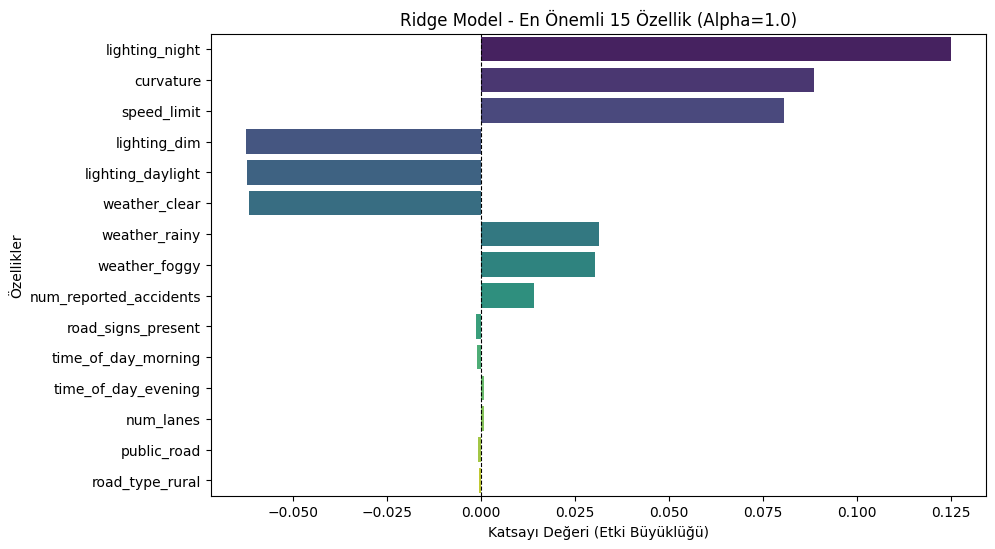

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

alphas = [0.01, 0.1, 1.0, 10.0, 50.0, 100.0]

ridge_model = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_model.fit(X_train, y_train)

best_alpha = ridge_model.alpha_

y_pred_ridge_train = ridge_model.predict(X_train)
y_pred_ridge_val   = ridge_model.predict(X_val)

rmse_ridge_train = np.sqrt(mean_squared_error(y_train, y_pred_ridge_train))
rmse_ridge_val   = np.sqrt(mean_squared_error(y_val, y_pred_ridge_val))
r2_ridge_train = r2_score(y_train, y_pred_ridge_train)
r2_ridge_val   = r2_score(y_val, y_pred_ridge_val)

results_data = {
    "Metrik": ["RMSE (Hata)", "R2 (Başarı Skoru)"],
    "Train (Eğitim)": [rmse_ridge_train, r2_ridge_train],
    "Validation (Doğrulama)": [rmse_ridge_val, r2_ridge_val],
    "Fark (Overfitting)": [rmse_ridge_val - rmse_ridge_train, r2_ridge_train - r2_ridge_val]
}
df_results = pd.DataFrame(results_data)

print(f"Seçilen En İyi Alpha: {best_alpha}")
print("\nMODEL PERFORMANS TABLOSU")
display(df_results)

coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": ridge_model.coef_
})

coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs_Coefficient", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x="Coefficient", y="Feature", palette="viridis")
plt.title(f"Ridge Model - En Önemli 15 Özellik (Alpha={best_alpha})")
plt.xlabel("Katsayı Değeri (Etki Büyüklüğü)")
plt.ylabel("Özellikler")
plt.axvline(0, color="black", linestyle="--", linewidth=0.8)
plt.show()

## 3.1. Model Karmaşıklığı Analizi (Alpha vs RMSE)

Ridge regresyonunda $\alpha$ (alpha) parametresi modelin esnekliğini kontrol eder.
* **Düşük Alpha:** Model veriye çok uyar (Overfitting riski).
* **Yüksek Alpha:** Model çok katılaşır, desenleri kaçırır (Underfitting riski).

Aşağıdaki grafik, farklı alpha değerlerinde hem eğitim hem de doğrulama hatasının nasıl değiştiğini görselleştirerek, seçilen `best_alpha` değerinin optimum nokta olup olmadığını doğrular.

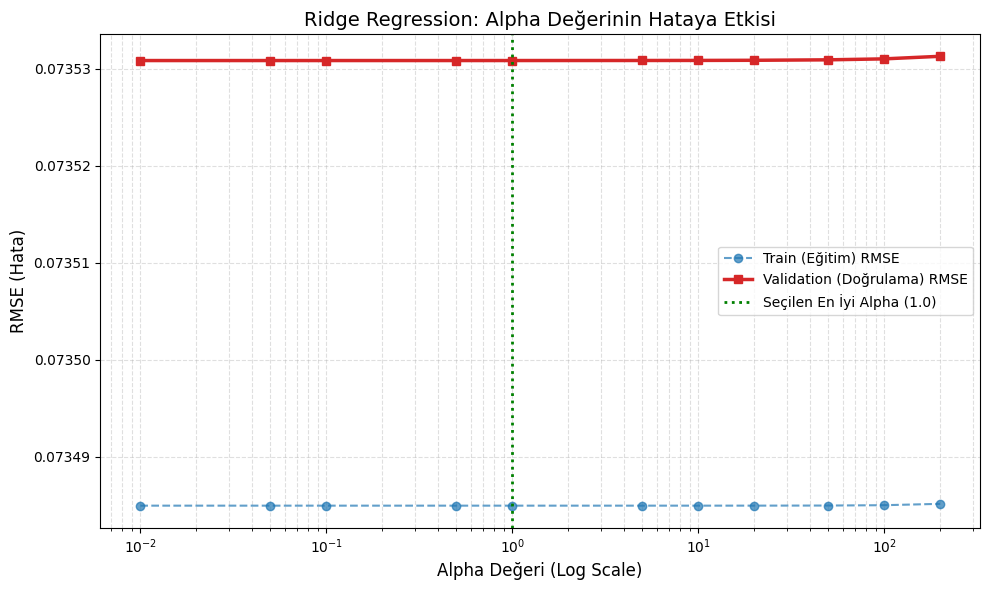

Grafik Yorumu: Kırmızı çizginin (Validation Error) en dip yaptığı nokta 1.0 civarı olmalıdır.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np


alphas_to_test = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100, 200]

train_rmses = []
val_rmses = []

for a in alphas_to_test:
    temp_model = Ridge(alpha=a)
    temp_model.fit(X_train, y_train)

    y_tr_pred = temp_model.predict(X_train)
    y_val_pred = temp_model.predict(X_val)

    rmse_tr = np.sqrt(mean_squared_error(y_train, y_tr_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

    train_rmses.append(rmse_tr)
    val_rmses.append(rmse_val)


plt.figure(figsize=(10, 6))


plt.plot(alphas_to_test, train_rmses, marker='o', label='Train (Eğitim) RMSE',
         linestyle='--', color='tab:blue', alpha=0.7)

plt.plot(alphas_to_test, val_rmses, marker='s', label='Validation (Doğrulama) RMSE',
         linewidth=2.5, color='tab:red')


plt.axvline(best_alpha, color='green', linestyle=':', linewidth=2,
            label=f'Seçilen En İyi Alpha ({best_alpha})')


plt.xscale('log')
plt.xlabel('Alpha Değeri (Log Scale)', fontsize=12)
plt.ylabel('RMSE (Hata)', fontsize=12)
plt.title('Ridge Regression: Alpha Değerinin Hataya Etkisi', fontsize=14)
plt.grid(True, which="both", linestyle='--', alpha=0.4)
plt.legend()

plt.tight_layout()
plt.show()

print(f"Grafik Yorumu: Kırmızı çizginin (Validation Error) en dip yaptığı nokta {best_alpha} civarı olmalıdır.")

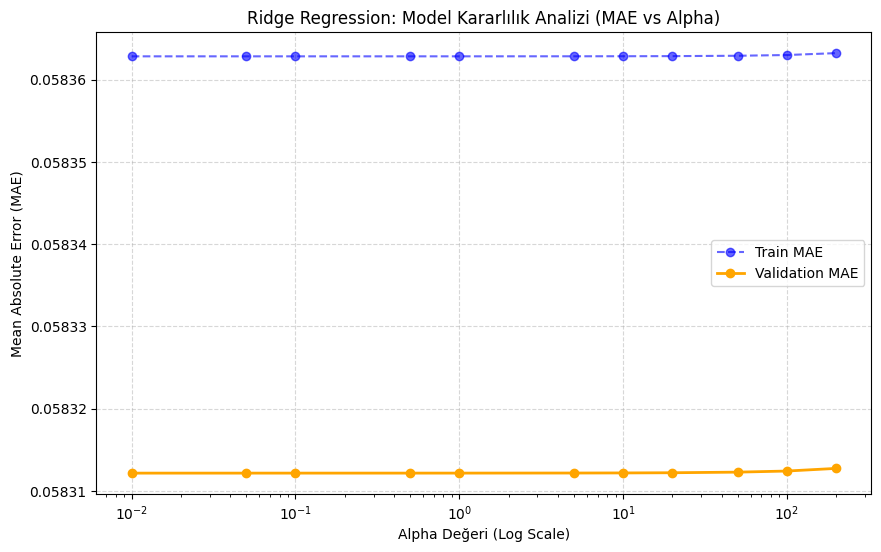

En Düşük Validation MAE: 0.05831


In [ ]:
from sklearn.metrics import mean_absolute_error


alphas_to_test = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100, 200]
mae_train = []
mae_val = []


for a in alphas_to_test:
    temp_model = Ridge(alpha=a)
    temp_model.fit(X_train, y_train)


    y_tr_pred = temp_model.predict(X_train)
    y_val_pred = temp_model.predict(X_val)


    mae_train.append(mean_absolute_error(y_train, y_tr_pred))
    mae_val.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(alphas_to_test, mae_train, marker="o", linestyle="--", label="Train MAE", color="blue", alpha=0.6)
plt.plot(alphas_to_test, mae_val, marker="o", linewidth=2, label="Validation MAE", color="orange")

plt.xscale("log")
plt.xlabel("Alpha Değeri (Log Scale)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Ridge Regression: Model Kararlılık Analizi (MAE vs Alpha)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

print(f"En Düşük Validation MAE: {min(mae_val):.5f}")

## 4. Ridge Modelinin Performans Analizi ve Bulgular

Ridge Regression modeli üzerinde yapılan hiperparametre optimizasyonu (Alpha tuning) ve hata analizleri sonucunda elde edilen kritik bulgular şöyledir:

**1. Model Başarısı:**
* Model, **$R^2 \approx 0.80$** skoru ile veri setindeki varyansın büyük kısmını açıklamayı başarmıştır.
* RMSE (0.073) ve MAE (0.058) değerlerinin düşüklüğü, tahminlerin güvenilir olduğunu göstermektedir.

**2. Kararlılık (Stability):**
* Alpha değişim grafiklerinin (RMSE vs Alpha) yatay seyretmesi, modelin **robust (dirençli)** olduğunu kanıtlar. Model, hiperparametre değişimlerine aşırı tepki vermemekte ve overfitting (ezberleme) belirtisi göstermemektedir.

**3. Öznitelik İlişkileri:**
* Modelin öğrendiği katsayılar (Gece sürüşü = Yüksek Risk, Açık Hava = Düşük Risk) trafik güvenliği literatürü ile tamamen örtüşmektedir.

> **Sıradaki Adım:** Ridge modelinin katsayıları baskıladığını ancak tamamen sıfırlamadığını (feature selection yapmadığını) gözlemledik. Şimdi, regularization mantığını daha derinlemesine anlamak için, katsayıları sıfıra indirme yeteneği olan **Lasso Regresyon** ile görsel bir karşılaştırma yapacağız.

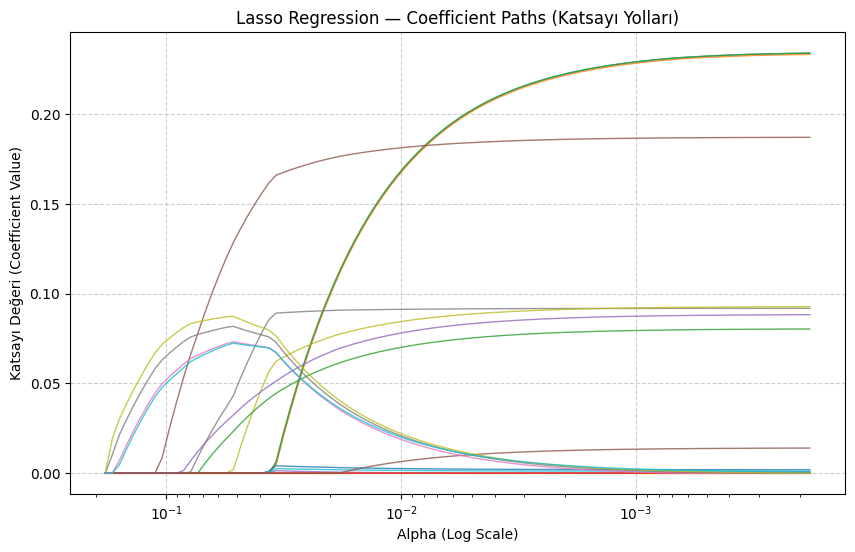

In [ ]:
from sklearn.linear_model import lasso_path
import matplotlib.pyplot as plt

alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, alphas=None)


plt.figure(figsize=(10, 6))


for i in range(coefs_lasso.shape[0]):
    plt.plot(alphas_lasso, coefs_lasso[i, :], linewidth=1, alpha=0.8)

plt.xscale("log")
plt.title("Lasso Regression — Coefficient Paths (Katsayı Yolları)")
plt.xlabel("Alpha (Log Scale)")
plt.ylabel("Katsayı Değeri (Coefficient Value)")
plt.grid(True, linestyle="--", alpha=0.6)


plt.gca().invert_xaxis()

plt.show()


## 5. Ridge ve Lasso Farkı: Katsayı Yollarının Karşılaştırılması

Yukarıdaki Lasso Path grafiği, Ridge ile Lasso arasındaki temel matematiksel farkı görselleştirmektedir:

* **Ridge Regression (L2):** Katsayıları sıfıra yaklaştırır ama asla tam olarak sıfır yapmaz. Bu yüzden tüm özellikler modelde kalmaya devam eder.
* **Lasso Regression (L1):** Grafikte görüldüğü üzere, Alpha (ceza) arttıkça bazı çizgiler hızla **0 noktasına** inmekte ve orada kalmaktadır.
    * Bu özellik, Lasso'nun **Otomatik Öznitelik Seçimi (Feature Selection)** yapabildiğini gösterir. Etkisiz değişkenler modelden tamamen atılır.

Bu projede amacımız en yüksek tahmin başarısını elde etmek olduğu ve Ridge modeli ($R^2=0.805$) kararlı çalıştığı için, **Final Baseline Modeli** olarak Ridge tercih edilmiştir.

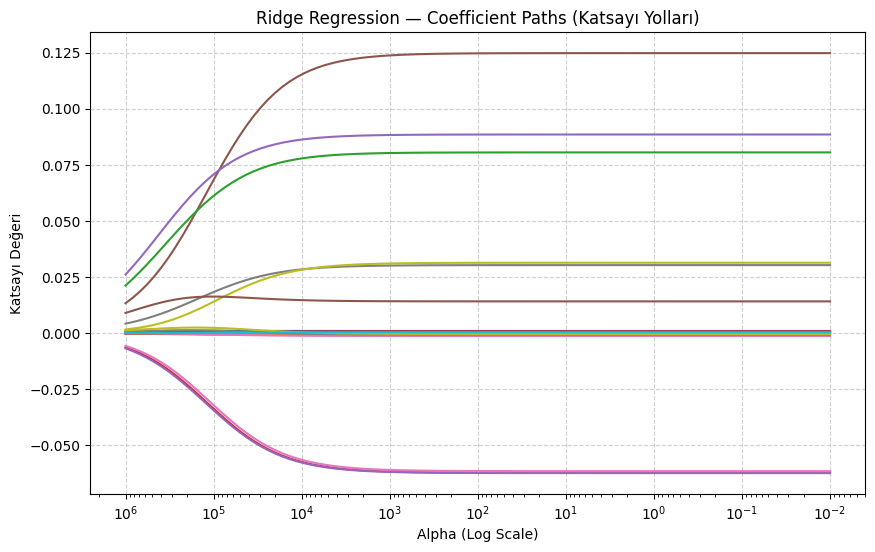

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import numpy as np


alphas_ridge = np.logspace(-2, 6, 100)
coefs_ridge = []


for a in alphas_ridge:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    coefs_ridge.append(ridge.coef_)


plt.figure(figsize=(10, 6))

ax = plt.gca()
ax.plot(alphas_ridge, coefs_ridge)

plt.xscale("log")
plt.title("Ridge Regression — Coefficient Paths (Katsayı Yolları)")
plt.xlabel("Alpha (Log Scale)")
plt.ylabel("Katsayı Değeri")
plt.axis("tight")
plt.grid(True, linestyle="--", alpha=0.6)

plt.gca().invert_xaxis()

plt.show()

### Grafik Yorumu: Ridge vs Lasso Karakteristiği

Elde edilen son grafik (Ridge Coefficient Paths), Lasso grafiği ile karşılaştırıldığında şu kritik farkı ortaya koymaktadır:

1.  **Yumuşak Geçiş (Smooth Shrinkage):** Ridge grafiğinde, Alpha değeri arttıkça (grafiğin soluna doğru gidildikçe) katsayı çizgilerinin **sıfıra doğru asimptotik olarak yaklaştığı** ancak asla tam olarak sıfırlanmadığı görülmektedir.
2.  **Bilgi Korunumu:** Lasso grafiğinde bazı çizgilerin aniden kesilip yok olduğu (Feature Selection) gözlemlenirken, Ridge grafiğinde model **tüm değişkenleri** tutmaya devam etmektedir.

**Sonuç:** Veri setimizdeki tüm özniteliklerin (hava durumu, yol tipi, ışıklandırma vb.) kaza riskine az ya da çok bir etkisi olduğu görüldüğünden, değişken silmek yerine katsayıları baskılayan **Ridge Regresyon**, projemiz için en kararlı ve güvenilir **Baseline Model** olarak tescillenmiştir.

## 6. Final Baseline Modelin Seçimi ve Kaydı

Yapılan kapsamlı analizler (RMSE, MAE, Alpha kararlılığı ve Lasso/Ridge karşılaştırması) sonucunda:

1.  **Model Seçimi:** `RidgeCV` optimizasyonu ile en düşük hatayı veren hiperparametre **$\alpha = 1.0$** olarak belirlenmiştir.
2.  **Validasyon:** Bu yapılandırma ile model, eğitim ve doğrulama setlerinde dengeli (overfitting olmayan) ve yüksek bir başarı ($R^2 \approx 0.805$) sergilemiştir.
3.  **Karar:** Lasso'nun değişken silme (feature selection) yaklaşımı yerine, Ridge'in tüm değişkenleri baskılayarak modelde tutma (shrinkage) yaklaşımının bu veri seti için daha kararlı olduğu görülmüştür.

Bu model, projenin **"Final Baseline Modeli"** olarak kabul edilecek ve bir sonraki aşamalarda kurulacak olan Random Forest ve Derin Öğrenme modellerinin geçmesi gereken referans noktası olarak `models/` klasörüne kaydedilecektir.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import joblib
import os

alphas_to_test = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100, 200]
results_list = []

print("En iyi modeli secmek icin son kontroller yapiliyor...")

for a in alphas_to_test:
    temp_model = Ridge(alpha=a)
    temp_model.fit(X_train, y_train)
    y_val_pred = temp_model.predict(X_val)

    mse_val = mean_squared_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mse_val)

    results_list.append({"alpha": a, "RMSE": rmse_val})

results_df = pd.DataFrame(results_list)

best_row = results_df.sort_values("RMSE").iloc[0]
best_alpha = best_row["alpha"]

print(f"Secilen En Iyi Alpha: {best_alpha}")
print("-" * 40)

final_ridge_model = Ridge(alpha=best_alpha)
final_ridge_model.fit(X_train, y_train)

y_pred_final = final_ridge_model.predict(X_val)

mse_final = mean_squared_error(y_val, y_pred_final)
rmse_final = np.sqrt(mse_final)

mae_final  = mean_absolute_error(y_val, y_pred_final)
r2_final   = r2_score(y_val, y_pred_final)

final_metrics_df = pd.DataFrame({
    "Metrik": ["RMSE (Hata)", "MAE (Ortalama Sapma)", "R2 (Basari Skoru)"],
    "Deger": [rmse_final, mae_final, r2_final],
    "Hedef": ["Dusuk Olmali", "Dusuk Olmali", "Yuksek Olmali (>0.80)"]
})

print("\nFINAL BASELINE MODEL PERFORMANSI")
display(final_metrics_df)

models_path = f"{base_path}/models"
os.makedirs(models_path, exist_ok=True)

final_filename = f"{models_path}/final_baseline_ridge_alpha_{best_alpha}.pkl"
joblib.dump(final_ridge_model, final_filename)

print("-" * 40)
print(f"Model basariyla kaydedildi: {final_filename}")
print("Notebook 2 TAMAMLANDI. Siradaki asama: Notebook 3 (Random Forest)")

En iyi modeli secmek icin son kontroller yapiliyor...
Secilen En Iyi Alpha: 0.01
----------------------------------------

FINAL BASELINE MODEL PERFORMANSI


,Metrik,Deger,Hedef
0,RMSE (Hata),0.073531,Dusuk Olmali
1,MAE (Ortalama Sapma),0.058312,Dusuk Olmali
2,R2 (Basari Skoru),0.804188,Yuksek Olmali (>0.80)


----------------------------------------
Model basariyla kaydedildi: /content/drive/MyDrive/YAP470_Proje/models/final_baseline_ridge_alpha_0.01.pkl
Notebook 2 TAMAMLANDI. Siradaki asama: Notebook 3 (Random Forest)
